In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "1INCHUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2022-01-01"
        self.end_date = "2022-03-04"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = True  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
fetching https://data.binance.vision/data/futures/um/monthly/klines/1INCHUSDT/1m/1INCHUSDT-1m-2022-01.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.47M/1.47M [00:00<00:00, 3.47MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/1INCHUSDT/1m/1INCHUSDT-1m-2022-02.zip


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.30M/1.30M [00:00<00:00, 3.07MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/1INCHUSDT/1m/1INCHUSDT-1m-2022-03.zip
HTTP Error 404: Not Found
'NoneType' object has no attribute 'to_csv'
fetching historical_data/ohlcvs_futures/1INCHUSDT/2022-03-01.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48.5k/48.5k [00:00<00:00, 558kB/s]


fetching historical_data/ohlcvs_futures/1INCHUSDT/2022-03-02.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48.5k/48.5k [00:00<00:00, 592kB/s]


fetching historical_data/ohlcvs_futures/1INCHUSDT/2022-03-03.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47.8k/47.8k [00:00<00:00, 604kB/s]

millis to load 89279 ticks 4274ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

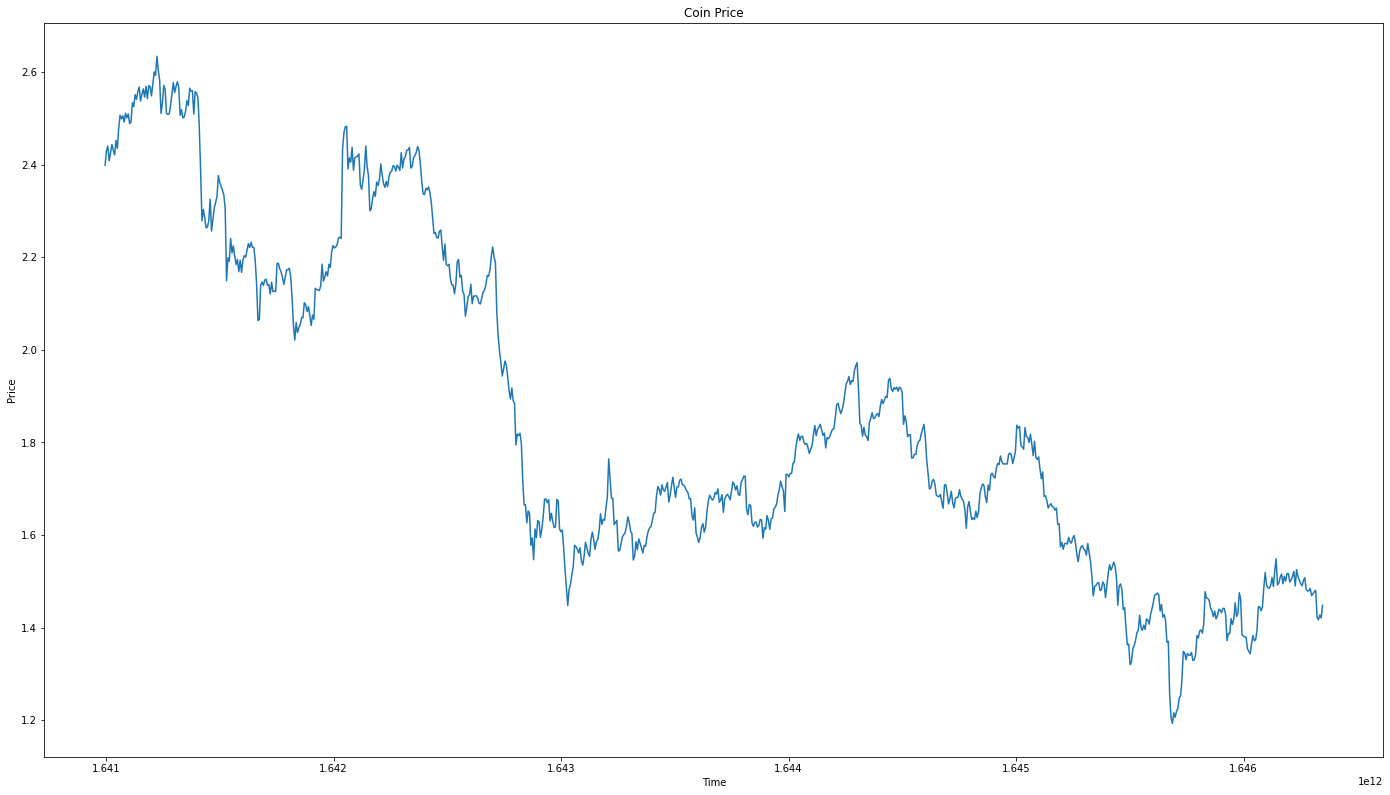

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [6]:
# choose a slice on which to test
wsize_days = 365
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [7]:
hand_tuned = {
    "config_name": "static_grid_1INCHUSDT_198days",
  "logging_level": 0,
  "long": {
    "auto_unstuck_ema_dist": 0.042442783008452035,
    "auto_unstuck_wallet_exposure_threshold": 0.9207998186225945,
    "ema_span_0": 1467.1216021417815,
    "ema_span_1": 2043.845592884267,
    "enabled": True,
    "eprice_exp_base": 1.2989141602944303,
    "eprice_pprice_diff": 0.023662414633603666,
    "grid_span": 0.25583954425089916,
    "initial_eprice_ema_dist": -0.03483738044116901,
    "initial_qty_pct": 0.08880814000569119,
    "markup_range": 0.029644924465494327,
    "max_n_entry_orders": 10,
    "min_markup": 0.036898444463317574,
    "n_close_orders": 8,
    "secondary_allocation": 0.390336852863754,
    "secondary_pprice_diff": 0.1683363553192447,
    "wallet_exposure_limit": 0.1
  },
  "short": {
    "auto_unstuck_ema_dist": 0.07692067495670571,
    "auto_unstuck_wallet_exposure_threshold": 0.367480315605299,
    "ema_span_0": 3949.259795824885,
    "ema_span_1": 10080,
    "enabled": True,
    "eprice_exp_base": 1.326708275533179,
    "eprice_pprice_diff": 0.014175680093106852,
    "grid_span": 0.25833394408930865,
    "initial_eprice_ema_dist": -0.06507125117727211,
    "initial_qty_pct": 0.0892236921421297,
    "markup_range": 0.0355007427669179,
    "max_n_entry_orders": 10,
    "min_markup": 0.04689404279519703,
    "n_close_orders": 5,
    "secondary_allocation": 0.056988382388130296,
    "secondary_pprice_diff": 0.3989914574846171,
    "wallet_exposure_limit": 0.14088425874015464
  }
}

# hand_tuned = load_live_config('configs/live/allround.json')
# hand_tuned['short']['enabled'] = True
config["starting_balance"] = Args().starting_balance
config["latency_simulation_ms"] = 1000
config_to_test = {**config, **numpyize(hand_tuned)}
dump_live_config(config_to_test, make_get_filepath(f"tmp/hand_tuned.json"))
hand_tuned

{'config_name': 'static_grid_1INCHUSDT_198days',
 'logging_level': 0,
 'long': {'auto_unstuck_ema_dist': 0.042442783008452035,
  'auto_unstuck_wallet_exposure_threshold': 0.9207998186225945,
  'ema_span_0': 1467.1216021417815,
  'ema_span_1': 2043.845592884267,
  'enabled': True,
  'eprice_exp_base': 1.2989141602944303,
  'eprice_pprice_diff': 0.023662414633603666,
  'grid_span': 0.25583954425089916,
  'initial_eprice_ema_dist': -0.03483738044116901,
  'initial_qty_pct': 0.08880814000569119,
  'markup_range': 0.029644924465494327,
  'max_n_entry_orders': 10,
  'min_markup': 0.036898444463317574,
  'n_close_orders': 8,
  'secondary_allocation': 0.390336852863754,
  'secondary_pprice_diff': 0.1683363553192447,
  'wallet_exposure_limit': 0.1},
 'short': {'auto_unstuck_ema_dist': 0.07692067495670571,
  'auto_unstuck_wallet_exposure_threshold': 0.367480315605299,
  'ema_span_0': 3949.259795824885,
  'ema_span_1': 10080,
  'enabled': True,
  'eprice_exp_base': 1.326708275533179,
  'eprice_pp

In [8]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 36.9022
{'DGstd_long': 0.0032233764872541745,
 'DGstd_short': 0.0022438170360344436,
 'adg_DGstd_ratio_long': -0.13104926524695582,
 'adg_DGstd_ratio_short': 0.19121690711843883,
 'adg_long': -0.000422421120268973,
 'adg_per_exposure_long': -0.00422421120268973,
 'adg_per_exposure_short': 0.003045448495147457,
 'adg_realized_long': -0.00043569101412488376,
 'adg_realized_per_exposure_long': -0.004356910141248838,
 'adg_realized_per_exposure_short': 0.0029712490057127922,
 'adg_realized_short': 0.00041860221370226824,
 'adg_short': 0.0004290557537701689,
 'avg_fills_per_day_long': 5.080702068795573,
 'avg_fills_per_day_short': 4.354887487539063,
 'biggest_psize_long': 708.0,
 'biggest_psize_quote_long': 1000.4377722230329,
 'biggest_psize_quote_short': 1410.9639000000002,
 'biggest_psize_short': 596.0,
 'closest_bkr_long': 1.0,
 'closest_bkr_short': 1.0,
 'eqbal_ratio_mean_long': 0.9942262156961926,
 'eqbal_ratio_mean_short': 0.9992363284777166,
 'eqbal_ratio_min_long': 

In [9]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1640995260000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,2.3986,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.0000000000,0.0000000000
1,1640995320000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,2.4007,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.0000000000,0.0000000000
2,1640995380000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,2.3959,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.0000000000,0.0000000000
3,1640995440000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,2.3964,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.0000000000,0.0000000000
4,1640995500000.0,0.0,0.0000000000,0.0,0.0000000000,0.0,0.0000000000,2.3989,1.0,1.0,10000.00000000,10000.0000000000,10000.00000000,10000.00000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89275,1646351760000.0,0.0,30.9407174317,682.0,1.4278903226,-348.0,1.4497063367,1.4350,1.0,1.0,9733.43305968,10262.8718610674,9738.28185968,10267.98966624,0.1000490982,0.0491575664
89276,1646351820000.0,0.0,30.9407174317,682.0,1.4278903226,-348.0,1.4497063367,1.4347,1.0,1.0,9733.43305968,10262.8718610674,9738.07725968,10268.09406624,0.1000490982,0.0491575664
89277,1646351880000.0,0.0,30.9407174317,682.0,1.4278903226,-348.0,1.4497063367,1.4364,1.0,1.0,9733.43305968,10262.8718610674,9739.23665968,10267.50246624,0.1000490982,0.0491575664
89278,1646351940000.0,0.0,30.9407174317,682.0,1.4278903226,-348.0,1.4497063367,1.4351,1.0,1.0,9733.43305968,10262.8718610674,9738.35005968,10267.95486624,0.1000490982,0.0491575664


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

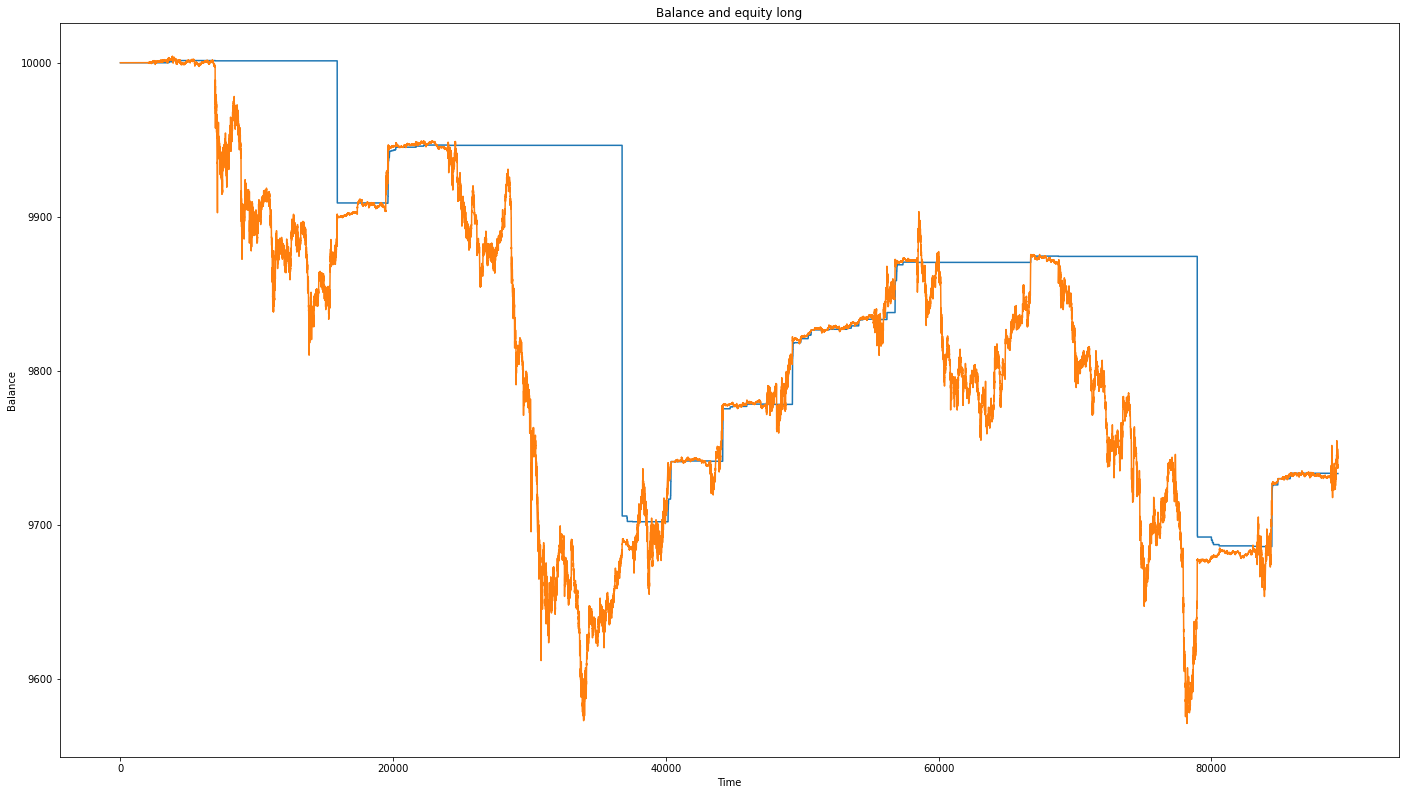

In [10]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

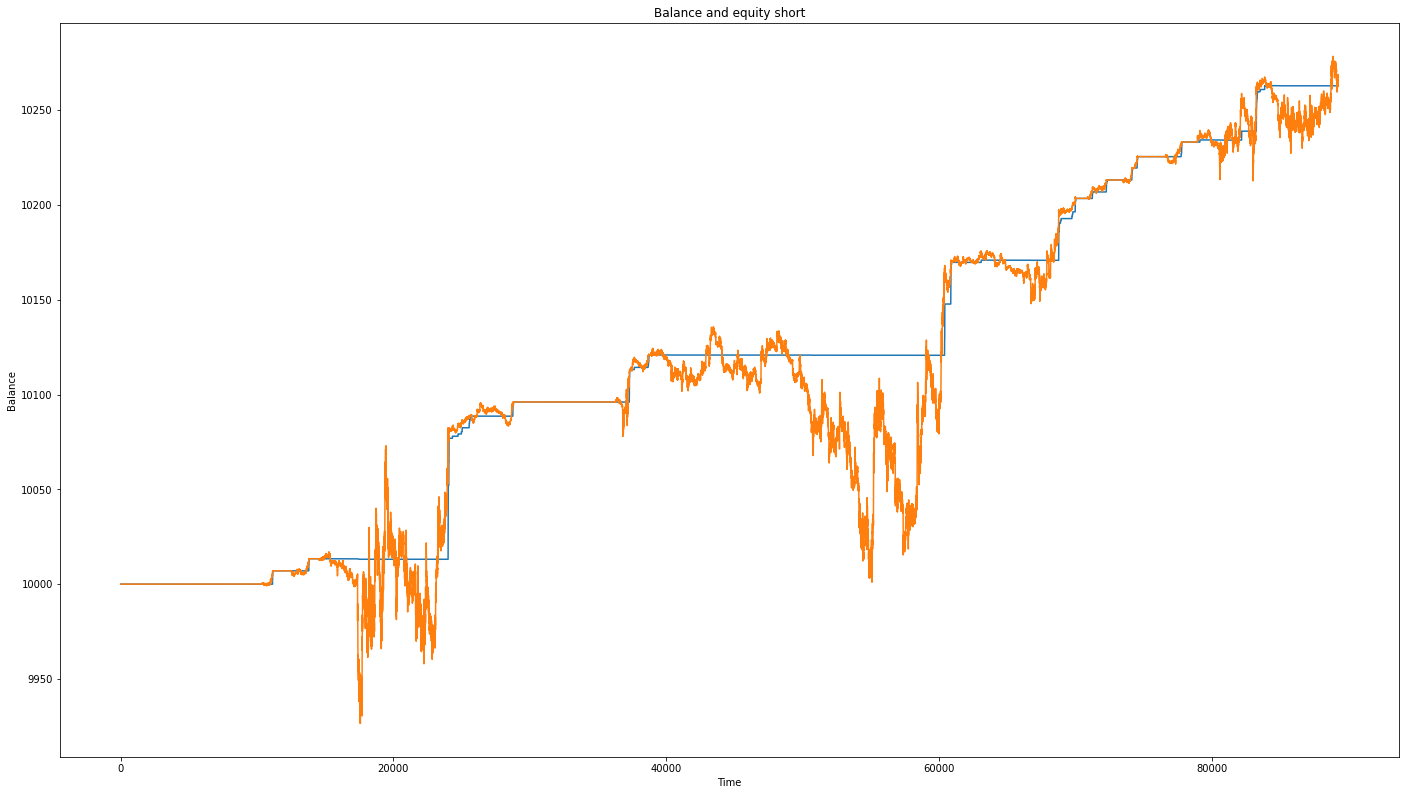

In [11]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

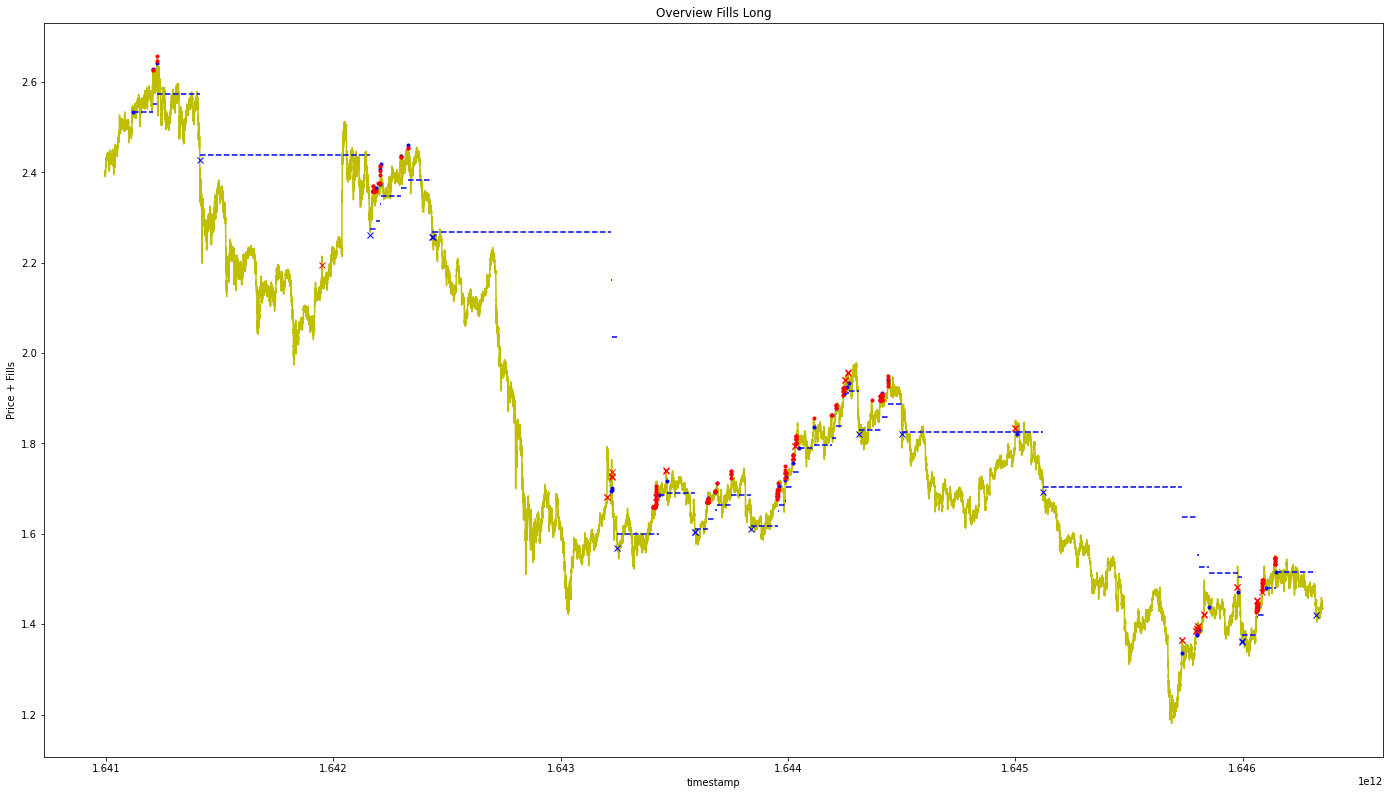

In [12]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

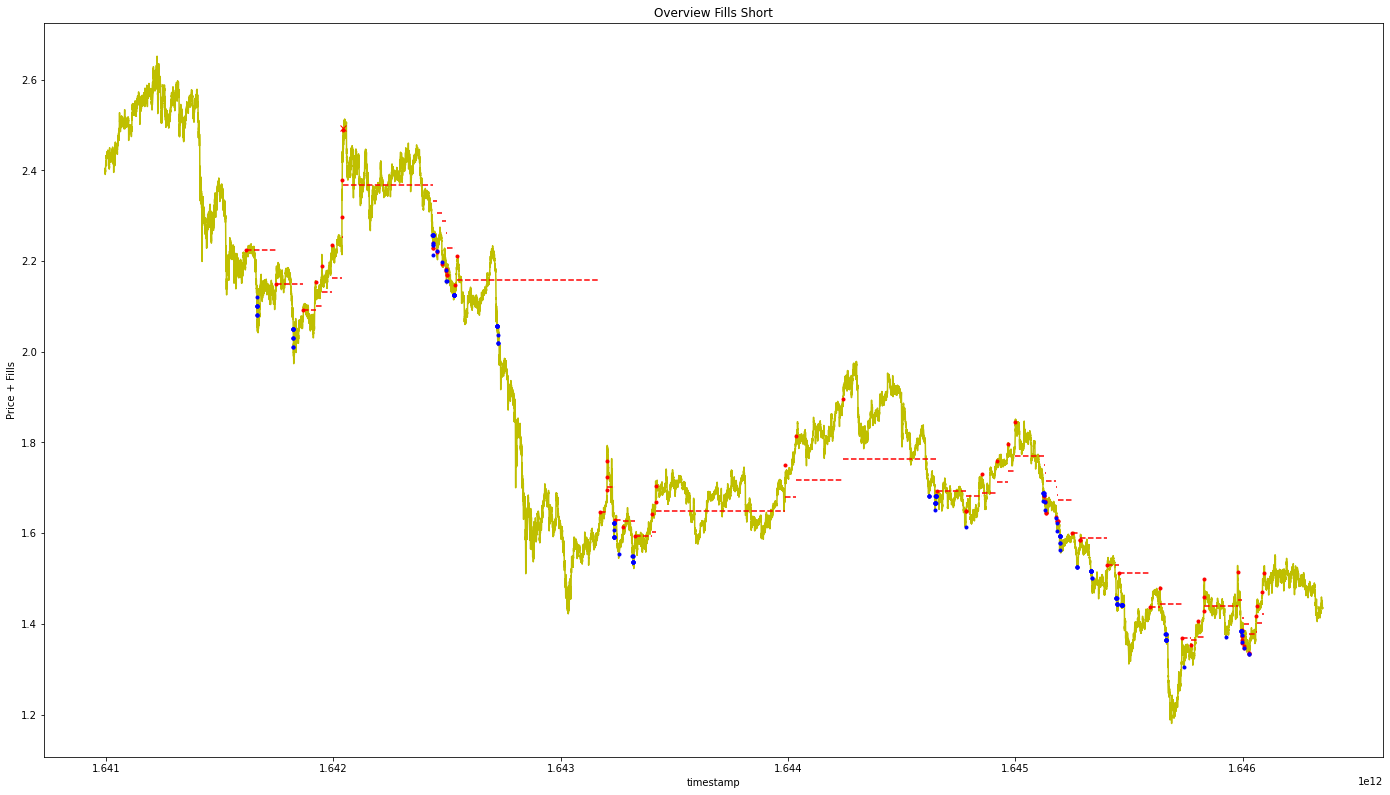

In [13]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

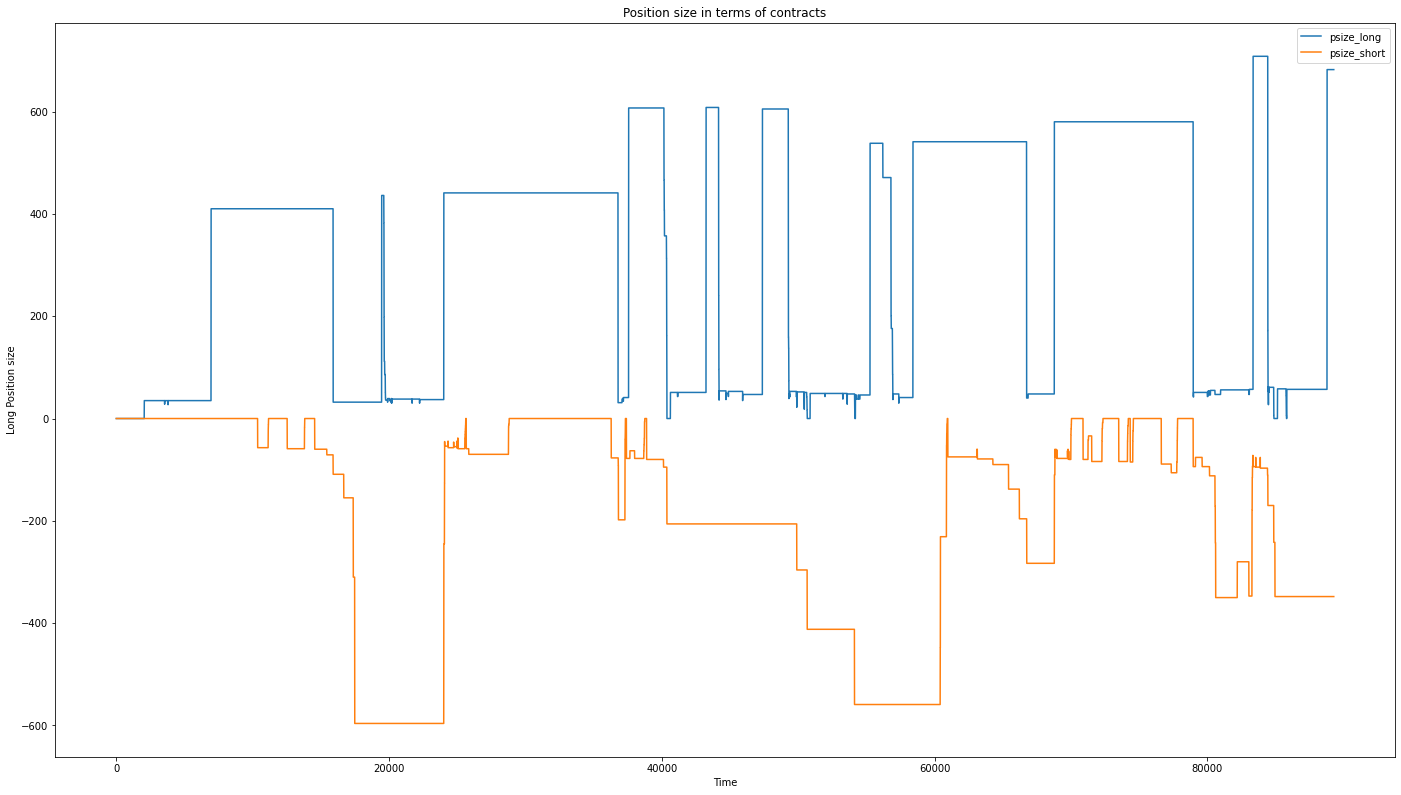

In [14]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

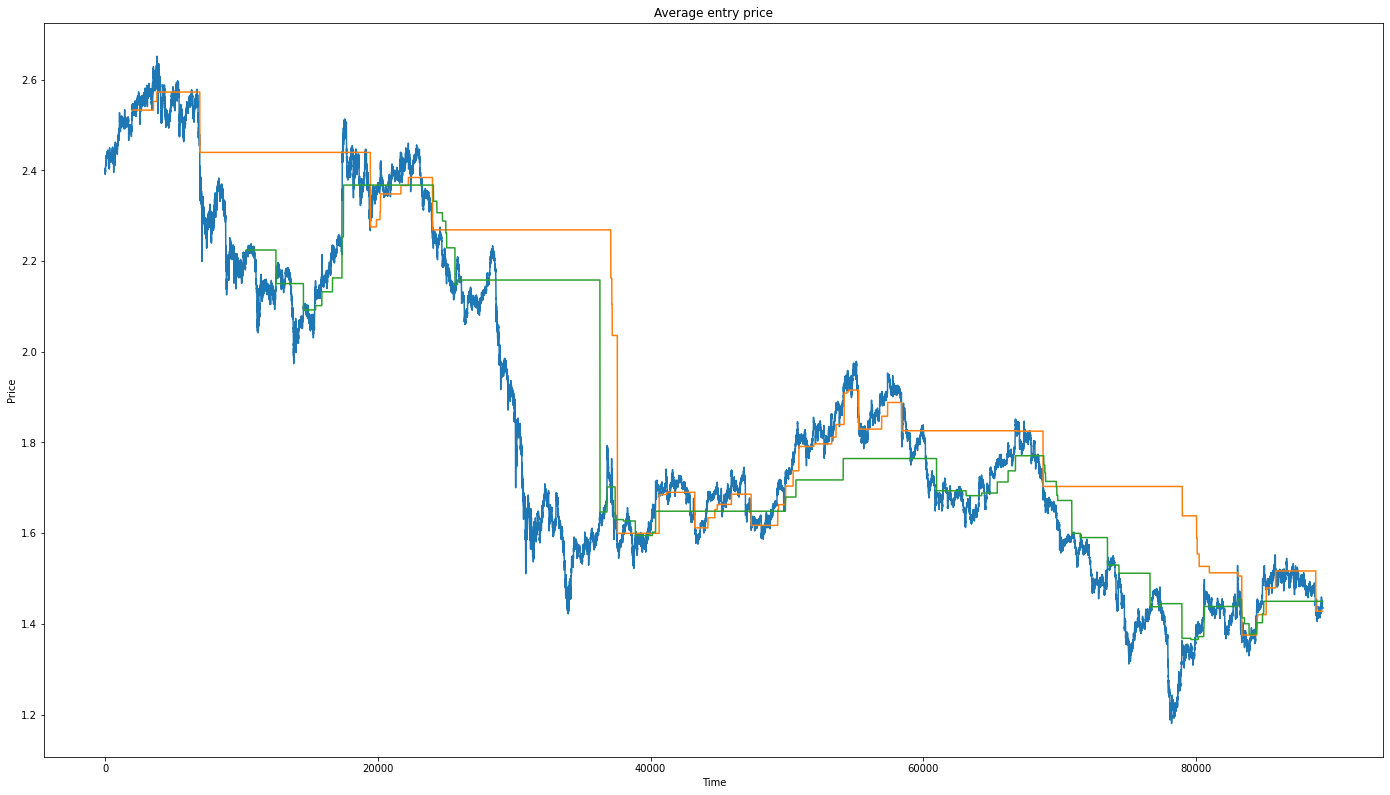

In [15]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.pprice_long.replace(0.0, np.nan).plot()
sdf.pprice_short.replace(0.0, np.nan).plot()

Mean price action distance long 0.090303


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

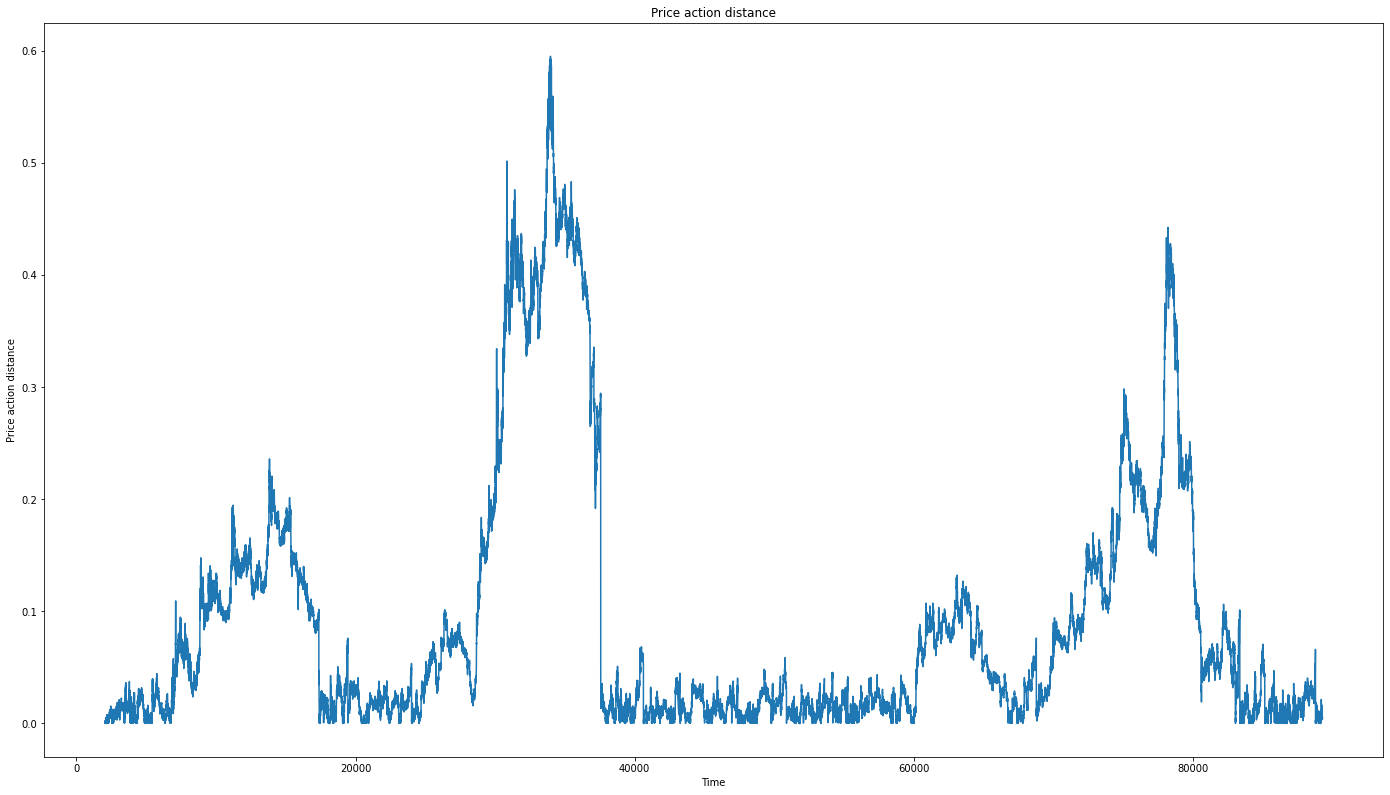

In [16]:
lpprices = sdf[sdf.pprice_long != 0.0]
pa_distance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Mean price action distance long {pa_distance_long.mean():.6f}")
pa_distance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.056994


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

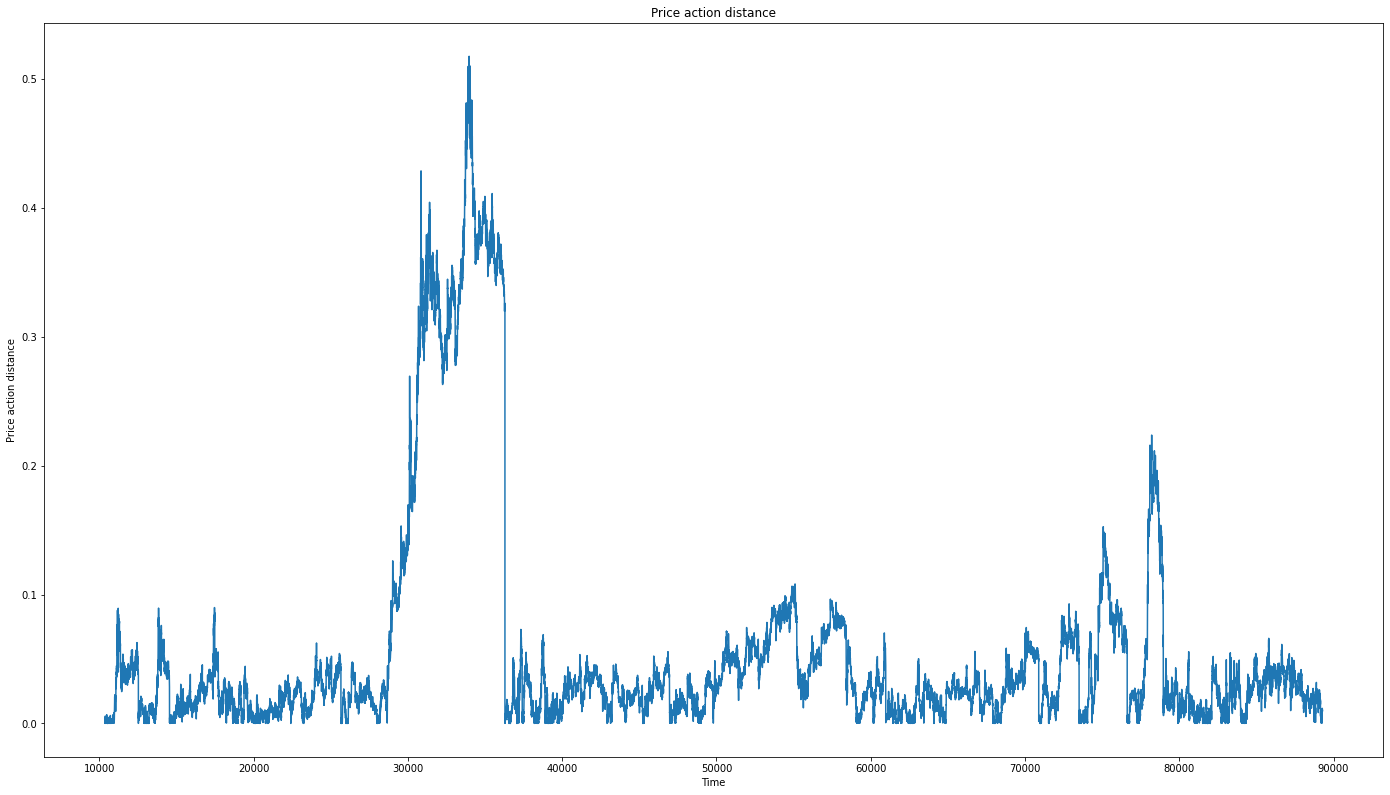

In [17]:
spprices = sdf[sdf.pprice_short != 0.0]
pa_distance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {pa_distance_short.mean():.6f}")
pa_distance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [1467.1216021417815, 1731.6379589171593, 2043.845592884267] n_days 62.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

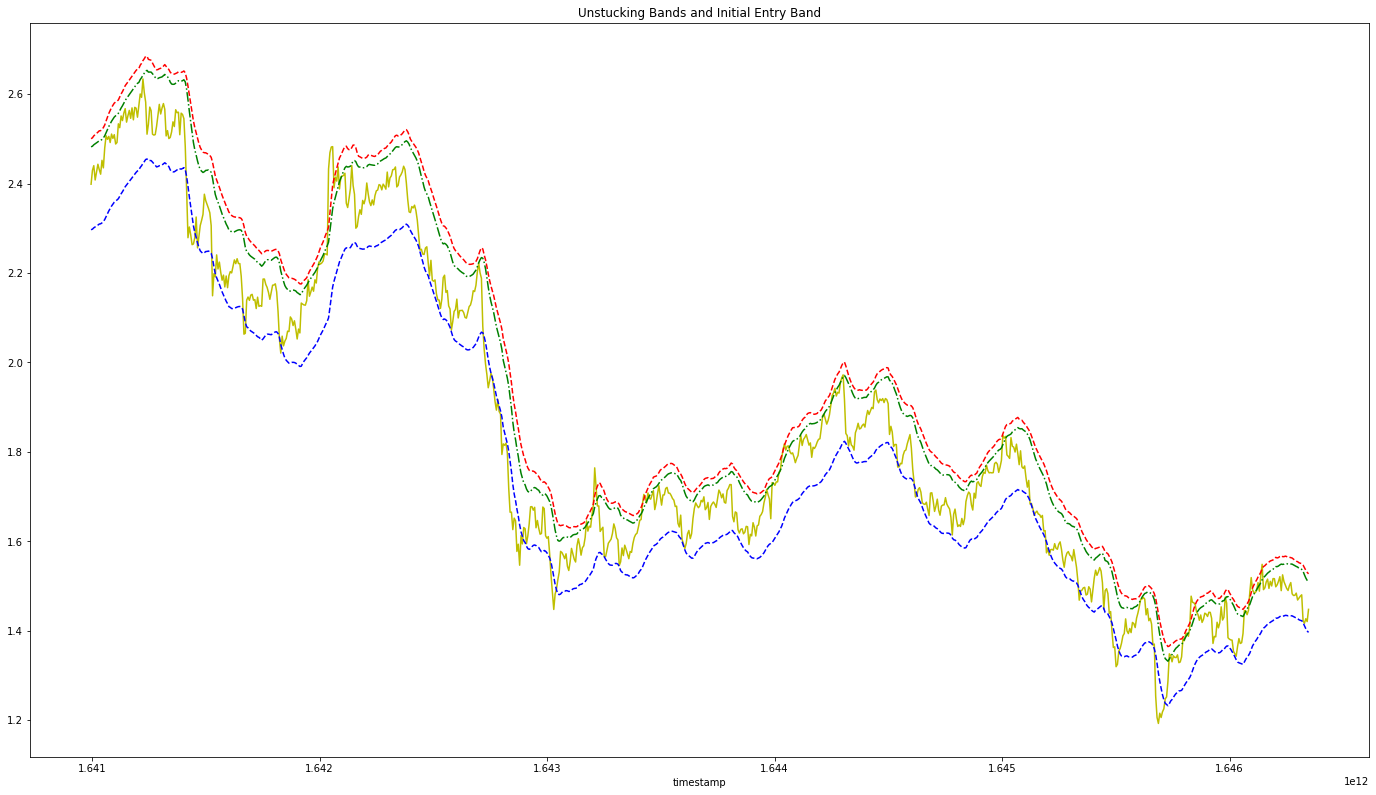

In [18]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [3949.259795824885, 6309.40082273387, 10080] n_days 62.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

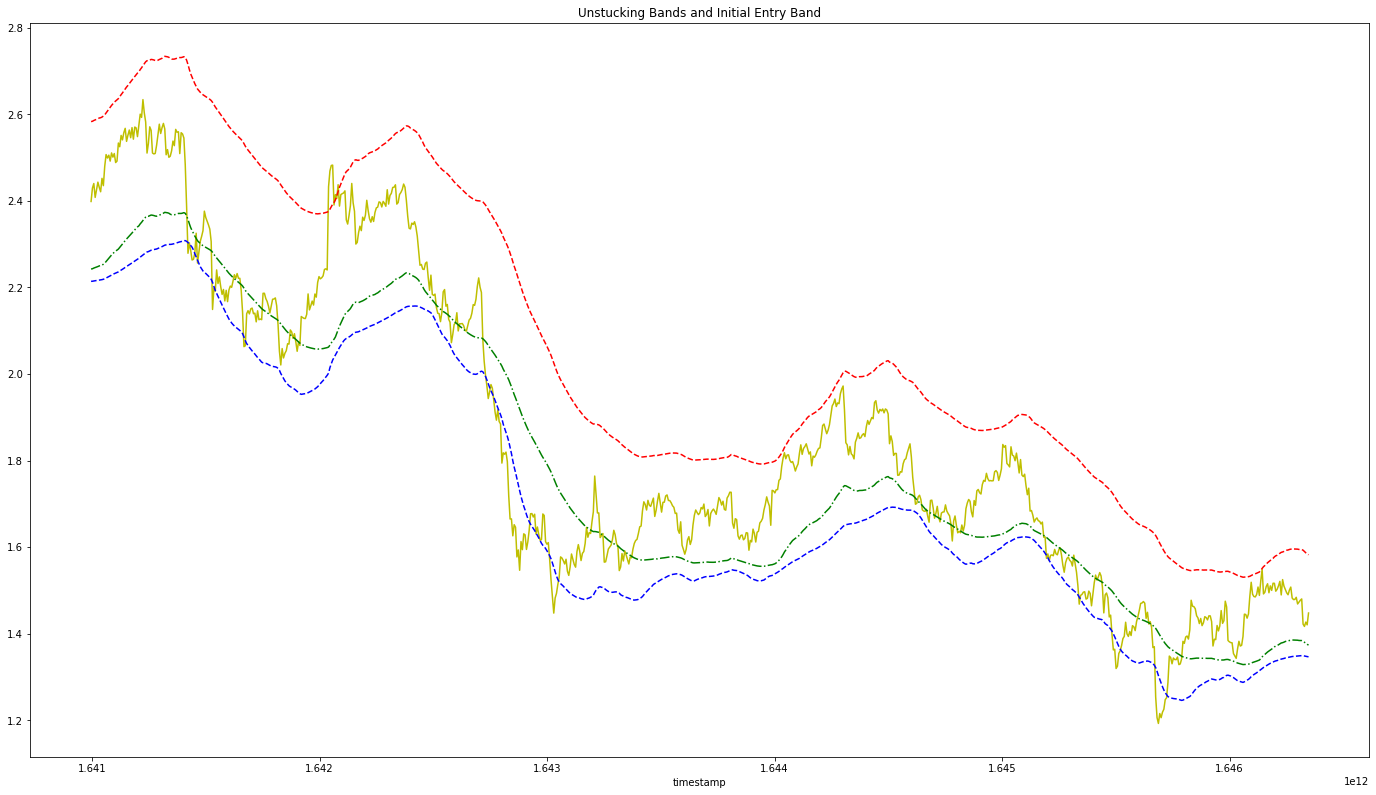

In [19]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")

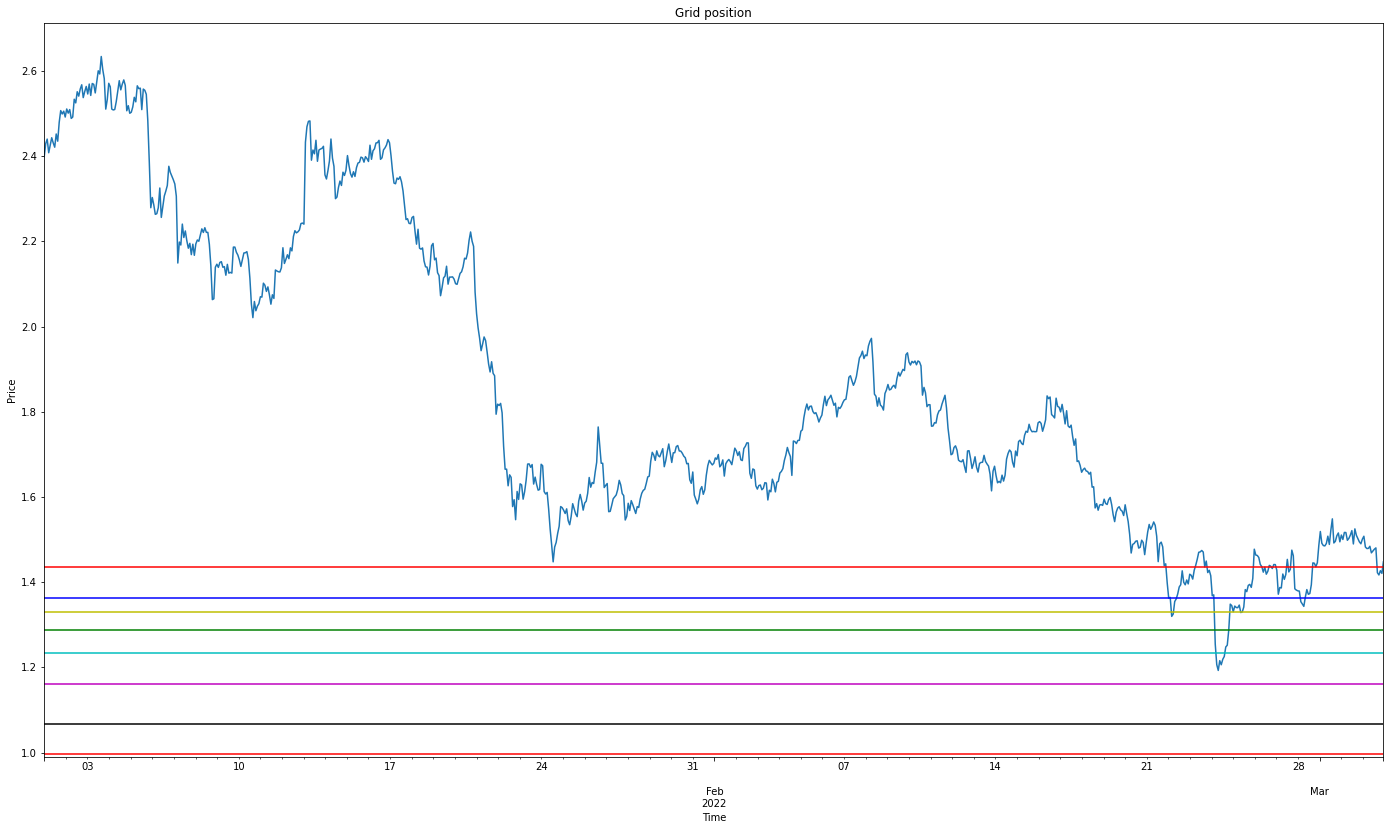

In [20]:
balance = config_to_test["starting_balance"]
highest_bid = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_long = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["long"]["grid_span"]
wallet_exposure_limit = config_to_test["long"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["long"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["long"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["long"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["long"]["eprice_exp_base"]
secondary_allocation = config_to_test["long"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["long"]["secondary_pprice_diff"]

grid = calc_whole_entry_grid_long(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [21]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nLong Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Long Grid Span = 30.54 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,62.0,1.4351,62.0,1.4351000000,0.00889762,0.0000000000,NaN,0.0
1,10.0,1.3639,72.0,1.4252111111,0.01026152,0.0449527906,0.1612903226,0.0
2,34.0,1.3311,106.0,1.3950245283,0.01478726,0.0480238362,0.4722222222,0.0
3,44.0,1.2885,150.0,1.3637773333,0.02045666,0.0584224551,0.4150943396,0.0
4,71.0,1.2331,221.0,1.3217950226,0.02921167,0.0719284913,0.4733333333,0.0
5,109.0,1.1613,330.0,1.2687830303,0.04186984,0.0925540604,0.4932126697,0.0
6,177.0,1.0679,507.0,1.1986522682,0.06077167,0.1224386818,0.5363636364,0.0
7,394.0,0.9968,901.0,1.1103839068,0.10004559,0.1139485421,0.7771203156,0.0


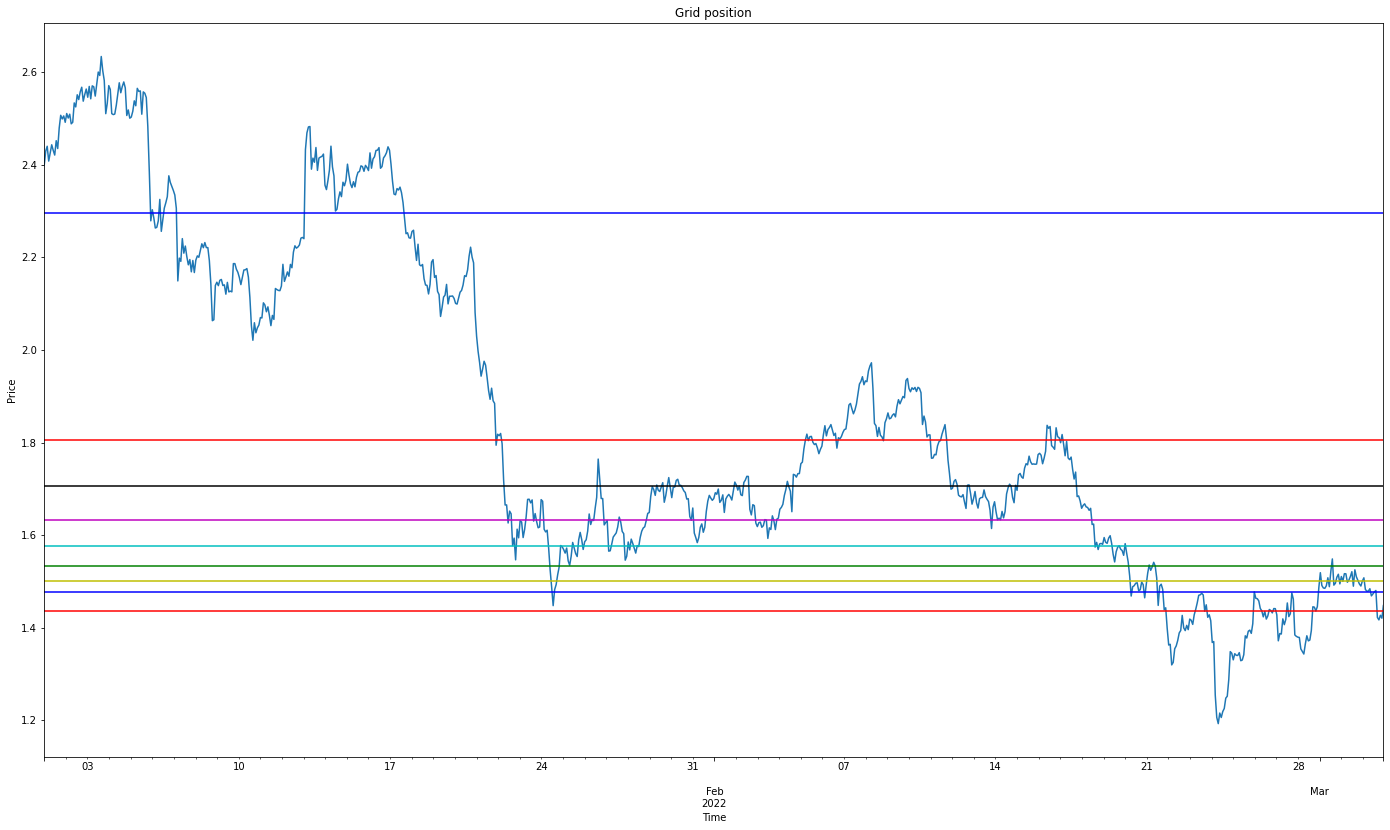

In [22]:
balance = config_to_test["starting_balance"]
lowest_ask = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_short = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["short"]["grid_span"]
wallet_exposure_limit = config_to_test["short"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["short"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["short"]["initial_qty_pct"]
eprice_pprice_diff = config_to_test["short"]["eprice_pprice_diff"]
eprice_exp_base = config_to_test["short"]["eprice_exp_base"]
secondary_allocation = config_to_test["short"]["secondary_allocation"]
secondary_pprice_diff = config_to_test["short"]["secondary_pprice_diff"]

grid = calc_whole_entry_grid_short(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eprice_pprice_diff,
    secondary_allocation,
    secondary_pprice_diff,
    eprice_exp_base=eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [23]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nShort Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Short Grid Span = -59.92 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,-88.0,1.4351,-88.0,1.4351000000,0.01262888,0.0000000000,NaN,115.0714636364
1,-16.0,1.4773,-104.0,1.4415923077,0.01499256,0.0241709147,0.1818181818,97.5954384615
2,-55.0,1.5014,-159.0,1.4622805031,0.02325026,0.0260553462,0.5288461538,64.3553622642
3,-67.0,1.5334,-226.0,1.4833646018,0.03352404,0.0326303627,0.4213836478,45.7311522124
4,-99.0,1.5758,-325.0,1.5115218462,0.04912446,0.0407908071,0.4380530973,32.2807526154
5,-126.0,1.6321,-451.0,1.5452088692,0.06968892,0.0532388523,0.3876923077,23.7181578714
6,-163.0,1.7068,-614.0,1.5881068404,0.09750976,0.0695413403,0.3614190687,17.8747517915
7,-194.0,1.8059,-808.0,1.6403987624,0.13254422,0.0916447409,0.3159609121,14.0166363861
8,-36.0,2.2950,-844.0,1.6683201422,0.14080622,0.2730631189,0.0445544554,13.5166613744
